In [57]:
# TODO 

# Data loading
# ------------
# which load forecast error do I use for NYISO?

# I would suggest you use the shifted twitter data (i.e., Normalized Sandy Tweet 
# Counts time-shifted by the lag that maximizes cross-correlation between tweet counts 
# and NYISO or NYCTLC)

# Analysis
# --------
# data stationarity and Hyndman is broken, and I can't generate my models any more :(

# include twitter data from all of nyc for NYISO (and potentially NYCTLC) for more dense data

# the reason your exogenous data isn't helping is because it's all zeros during the time you're predicting!
# switch to linearly interpolated twitter data from Huy

# improve Hyndman ARMA fitting implementation

# plot arma model residues (https://www.kaggle.com/poiupoiu/how-to-use-sarimax)

# get MSE between the forecast and the actual data


# Cleanup
# -------
# document your functions by copying into vs code, using autodocstring

# make sure it works with the refactored repo


# Imports + Load Data

In [58]:
%matplotlib inline
import sys
import os
sys.path.append(os.path.abspath('../'))

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import boxcox
from scipy.signal import correlate
from numpy.random import rand
import pandas as pd
from datetime import timedelta  
from statsmodels.tsa.stattools import grangercausalitytests, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults

import seaborn as sns
sns.set()

import twitterinfrastructure.analysis as asys
from twitterinfrastructure.tools import connect_db, output, query
import twitterinfrastructure.twitter_sandy as ts
import twitterinfrastructure.analyze_nyctlc as analyze
import importlib
importlib.reload(analyze)

print(os.getcwd())

# Comment these out b/c they mess up the plots generated by ARMA model
# matplotlib.rc('text', usetex=True)
# matplotlib.rc('font', **{'family': "serif"})
# params = {'text.latex.preamble': [r'\usepackage{siunitx}', 
#                                   r'\usepackage{amsmath}']}
# plt.rcParams.update(params)
sns.set_context('paper')
sns.set_style('darkgrid')


C:\dev\research\socialsensing\notebooks


In [59]:
## helpful functions
# TODO this doesn't work for max_arma_param > 5 since nonstationary data
def hyndman_arma_fit(data, exog=None, max_arma_param = 5):
    # fit ARMA
    if (exog == None):
        # fit an initial model
        model_00 = ARMA(data, order = (0,0)).fit()
        model_22 = ARMA(data, order = (2,2)).fit()
        model_10 = ARMA(data, order = (1,0)).fit()
        model_01 = ARMA(data, order = (0,1)).fit()
        models = []
        models.append(model_00)
        models.append(model_22)
        models.append(model_10)
        models.append(model_01)

        aic_init = []
        for i in range(len(models)):
            aic_init.append(models[i].aic)
        
        model_idx = np.argmin(aic_init)
        best_aic = aic_init[model_idx]
        best_model = models[model_idx]
        
        for p in range(1, max_arma_param):
            for q in range(1, max_arma_param):
                curr_model = ARMA(data, order = (p,q)).fit()
                curr_aic = curr_model.aic
                if curr_aic <= best_aic:
                    best_aic = curr_aic
                    best_model = curr_model
    
    # fit ARMAX
    else:
        # fit an initial model
        model_00 = ARMA(data, order = (0,0),exog = exog).fit()
        model_22 = ARMA(data, order = (2,2),exog = exog).fit()
        model_10 = ARMA(data, order = (1,0),exog = exog).fit()
        model_01 = ARMA(data, order = (0,1),exog = exog).fit()
        models = []
        models.append(model_00)
        models.append(model_22)
        models.append(model_10)
        models.append(model_01)

        aic_init = []
        for i in range(len(models)):
            aic_init.append(models[i].aic)
        
        model_idx = np.argmin(aic_init)
        best_aic = aic_init[model_idx]
        best_model = models[model_idx]
        
        for p in range(1, max_arma_param):
            for q in range(1, max_arma_param):
                curr_model = ARMA(data, order = (p,q), exog=exog).fit()
                curr_aic = curr_model.aic
                if curr_aic <= best_aic:
                    best_aic = curr_aic
                    best_model = curr_model
    
    return best_model


def compare_arma_armax(arma_model, armax_model, hours_forecast, num_training_points_plot, exog):
    '''
    exog (list): exogenous variable
    '''
    exog_predict = np.asarray(exog[-hours_forecast:])
    # get forecast and prediction intervals
    forecast_arma, PI_plus_arma, PI_minus_arma = \
        forecast_and_prediction_interval(arma_model, hours_forecast = hours_forecast)

    forecast_armax, PI_plus_armax, PI_minus_armax = \
        forecast_and_prediction_interval(armax_model, hours_forecast = hours_forecast, exog = exog_predict)

    # set up x-axis and real data to plot
    taxi_plot = taxi_train[-num_training_points_plot:] + taxi_test[0:hours_forecast]
    date_plot = date_train[-num_training_points_plot:] + date_test[0:hours_forecast]
    date_forecast = date_test[0:hours_forecast]

    # plot the real data (training + test)
    fig, ax = plt.subplots(figsize = (15,6))
    plt.plot(date_plot, taxi_plot, label = 'Data', color = 'blue')
    # plot ARMA forecast
    plt.plot(date_forecast, forecast_arma, label = 'Forecast (ARMA)', color = 'red')
    plt.fill_between(date_forecast, y1=PI_plus_arma, y2=PI_minus_arma, color = 'red', alpha=0.15)
    # plot ARMAX forecast
    plt.plot(date_forecast, forecast_armax, label = 'Forecast (ARMAX)', color = 'green')
    plt.fill_between(date_forecast, y1=PI_plus_armax, y2=PI_minus_armax, color = 'green', alpha=0.15)

    plt.xlabel('Date', fontsize = 16)
    plt.ylabel('Dropoffs per Hour', fontsize = 16)
    plt.title('Data vs Short-Term Forecasts During Hurricane Sandy', fontsize = 18)
    plt.legend(fontsize = 16, loc = 'upper left')
    plt.show()

    
def forecast_and_prediction_interval(model,hours_forecast, exog=None, alpha = 0.05):
    '''
    exog: (array) exogenous variable that helps prediction 
    '''
    if exog is None:
        for i in range(1, hours_forecast+1):
            forecast, stderr, conf_int = model.forecast(steps = hours_forecast, alpha=alpha)    

    else:
        for i in range(1, hours_forecast+1):
            forecast, stderr, conf_int = model.forecast(steps = hours_forecast, exog=exog,alpha=alpha)    

    
    # stderr gives a 2-sigma (95%) prediction interval    
    stderr_array = np.asarray(stderr)
    forecast_array   = np.asarray(forecast)
    forecast_plus = stderr_array + forecast_array
    forecast_minus = stderr_array - forecast_array
    return forecast, forecast_plus, forecast_minus


def gen_arma_model(data, num_predict, p = None, q = None, max_arma_param = 5, exog = None, \
                   start = 0, alpha = 0.05, \
                       plot = False, verbose = False, figsize = (15, 6)):
    '''
    data (array)
    exog (array)
    
    data and exog must be the same size, maybe check for this
    if exog = None, do an ARMA model, otherwise you have exogenous data and do ARMAX
    '''
    
    # fit ARMA model
    if exog is None:
        # check if data needs differencing with KPSS
        # our current dataset doesn't require differencing
        #TODO automated differencing
        stationary_bool_data, p_value_data = check_stationarity(data, significance_level=alpha, verbose=verbose)

        # manually choose ARMA params 
        if (p != None) and (q != None): 
            model = ARMA(data, order = (p,q))
            trained_model = model.fit()
        # run Hyndman to optimize
        else:
            if verbose:
                print("Using Hyndman's method for ARMA parameter determination")
            trained_model = hyndman_arma_fit(data, max_arma_param = max_arma_param)
        if plot:
            end = len(data)
            fig, ax = plt.subplots(figsize = figsize)
            trained_model.plot_predict(start=start, end = end + num_predict, alpha = alpha, ax = ax)
            plt.show()    
    
    # fit ARMAX model            
    else:
        # check if data needs differencing with KPSS
        # our current dataset doesn't require differencing
        #TODO automated differencing
        stationary_bool_exog, p_value_exog = check_stationarity(exog, significance_level=alpha, verbose=verbose)
        # manually choose ARMA params 
        if (p != None) and (q != None): 
            model = ARMA(data, order = (p,q), exog = exog)
            trained_model = model.fit()
        # run Hyndman to optimize
        else:
            if verbose:
                print("Using Hyndman's method for ARMA parameter determination")
            trained_model = hyndman_arma_fit(data, exog, max_arma_param = max_arma_param)
        if plot:
            end = len(data)
            fig, ax = plt.subplots(figsize = figsize)
            trained_model.plot_predict(start=start, end = end + num_predict, alpha = alpha, ax = ax, exog = exog)
            plt.show()
    return trained_model


def check_stationarity(x, significance_level, verbose = False):
    '''
    inputs{
    x (array-like): timeseries data
    significance_level (float): level at which to accept or reject null hypothesis
    }
    
    returns{
        stationarity_bool: 0 if timeseries not stationary, 1 if timeseries is stationary 
    }
    
    notes{
    Null Hypothesis: the input timeseries is level or trend stationary
    If p <= 0.05, reject the null hypothesis
    If p > 0.05, (weakly) accept the null hypothesis
    when in doubt, report p-values for the readers to make their own judgements
    }
    '''
    kpss_out = kpss(x)
    # check the p-value, com    
    if kpss_out[1] <= significance_level:
        if verbose:
            print('The timeseries is not stationary with p-value of {}'.format(kpss_out[1]))
        return 0, kpss_out[1]
    elif kpss_out[1] > significance_level:
        if verbose:
            print('The timeseries is stationary with p-value of {}'.format(kpss_out[1]))
        return 1, kpss_out[1]


# TODO add functionality to choose number of data points that are plotted (number of hours to plot)
def plot_univariate_data(x_axis, y_axis, mark_hours=24, show=True):
    """
    makes a 2x2 plot of the timeseries, a histogram of the timeseries, 
    the autocorrelation, and the partial autocorrelation
    
    Inputs:
    x_axis (array): x-axis values for the timeseries plots (dates)
    y_axis (array): y-axis values for the timeseries plots (timeseries values)    
    """

    fig, ax = plt.subplots(2,2, figsize=(15,15))
    fontsize = 20
    
    # timeseries plot
    sns.lineplot(x_axis, y_axis, ax=ax[0,0])
    ax[0,0].set_title('Timeseries Plot', fontsize=fontsize, fontweight='semibold')
    ax[0,0].set_xlabel(x_axis.name, fontsize = fontsize-5)
    ax[0,0].set_ylabel(y_axis.name, fontsize = fontsize-5)
    plt.sca(ax[0,0])
    plt.xticks(rotation = 45)
    
    # timeseries histogram 
    sns.distplot(y_axis, ax=ax[0,1])
    ax[0,1].set_title('Timeseries Histogram', fontsize=fontsize, fontweight='semibold')
    ax[0,1].set_xlabel(y_axis.name, fontsize = fontsize-5)
    ax[0,1].set_ylabel('Frequency', fontsize = fontsize-5)
    
    # autocorrelation
    plot_acf(y_axis, markevery=mark_hours, ax=ax[1,0])
    ax[1,0].set_title('Autocorrelation Function', fontsize=fontsize, fontweight='semibold')
    ax[1,0].set_xlabel('Lags', fontsize = fontsize-5)
    ax[1,0].set_ylabel('ACF', fontsize = fontsize-5)

    # partial autocorrelation
    plot_pacf(y_axis, markevery=mark_hours, ax=ax[1,1])
    ax[1,1].set_title('Partial Autocorrelation Function', fontsize=fontsize, fontweight='semibold')
    ax[1,1].set_xlabel('Lags', fontsize = fontsize-5)
    ax[1,1].set_ylabel('PACF', fontsize = fontsize-5)

    fig.tight_layout()
    if show:
        plt.show()
     
    return


# TODO this is a dumb implemntation
def differencing(df_input, hours_diff, diff_col_str):
    # perform differencing on dataset
    df_output = df_input.copy()
    diff_data =  df_input[diff_col_str].diff(periods = hours_diff)

    df_output[diff_col_str] = diff_data
    
    # remove rows with NaN in trip_count 
    mask = ~df_output[diff_col_str].isnull()
    df_output = df_output[mask]
    df_output = df_output.reset_index()
    del df_output['index']

    return df_output


def check_granger_causality(x1, x2, max_lag = 1, verbose = False):
    # Null hypothesis: the time series in the second column does NOT Granger
    # cause the time series in the first column.
    # We reject the null hypothesis that x2 does not Granger cause
    # x1 if the pvalues are below a desired size of the test.
    # If p <= 0.05, reject the null hypothesis
    # If p > 0.05, accept the null hypothesis

    # https://www.youtube.com/watch?v=ZUv7T8iPGrc
    # https://www.youtube.com/watch?v=6dOnNNxRJuY
    granger_input = np.zeros([len(x1), 2])
    granger_input[:, 0] = x1
    granger_input[:, 1] = x2
    results = grangercausalitytests(granger_input, maxlag = max_lag, verbose = verbose)
    return results


#TODO does this generalize to other dataframes?  Different start/end date ranges?
def invert_differencing(data, diff_forecast, hours_diff):
    raw_forecast = np.zeros(len(diff_forecast))
    for i in range(len(diff_forecast)):
        corresponding_data_idx = -hours_diff + i
        raw_forecast[i] = diff_forecast[i] + data[corresponding_data_idx]    
    return raw_forecast


def query_nyiso(start_date, end_date, db_path, verbose=0):
    """Query and clean nyiso load forecast error data for the specified date
    range from a sqlite database. Assumes the database contains a
    forecast_error table created using create_forecast_err.

    Parameters
    ----------
    start_date : Timestamp
        Start date to include tweets from (inclusive), specified as a
        timezone-aware Pandas Timestamp object.
        E.g. start_date = pd.Timestamp('2012-10-28 00:00:00',
        tz='America/New_York')

    end_date : Timestamp
        End date to include tweets from (exclusive), specified as a
        timezone-aware Pandas Timestamp object.
        e.g. enddate = pd.Timestamp('2012-11-03 00:00:00',
        tz='America/New_York')

    db_path : str
        Path to sqlite database containing table.

    verbose : int
        Defines verbosity for output statements.

    Returns
    -------
    df : dataframe

    Notes
    -----
    Sqlite date queries are inclusive for start and end, forecast_error
    datetimes are UTC.
    """

    if verbose >= 1:
        output('Started query.')

    # convert datetimes
    startdateUTC = start_date.tz_convert('UTC')
    enddateUTC = end_date.tz_convert('UTC') - pd.Timedelta('1 second')
    startdate_sql = startdateUTC.strftime("%Y-%m-%d %H:%M:%S")
    enddate_sql = enddateUTC.strftime("%Y-%m-%d %H:%M:%S")

    # load nyiso load data
    sql = """
            SELECT datetimeUTC, zone_id, integrated_load
            FROM load
            WHERE
                datetimeUTC BETWEEN '{startdate_sql}' AND '{enddate_sql}'
          """.format(startdate_sql=startdate_sql, enddate_sql=enddate_sql)
    df = query(db_path, sql)

    # convert datetimes
    df['datetimeUTC'] = pd.to_datetime(df['datetimeUTC'])
    df['datetimeUTC'] = [datetime.tz_localize(tz='UTC') for datetime in
                         df['datetimeUTC']]
    df['datetimeNY'] = [datetime.tz_convert('America/New_York') for
                        datetime in df['datetimeUTC']]

    # add and drop columns
    df = df.drop(['datetimeUTC'], axis=1)

    # index and sort
    df = df.sort_index(level=0)

    return df


def load_nyiso(start_date, end_date, zone_id, db_path):
    start_date = pd.Timestamp(start_date, 
                         tz='America/New_York')  # inclusive
    
    end_date = pd.Timestamp(end_date, 
                       tz='America/New_York') # exclusive

    # load nyiso load data (filtered by dates, grouped by zone-hour)
    df_query = query_nyiso(start_date, end_date, db_path, verbose=1)

    # choose the NYISO zone id and dates
    df_power = df_query.loc[df_query['zone_id'] == zone_id]
    df_power.rename(index=str, columns={'datetimeNY':'datetime'}, inplace=True)

    df_power = df_power.reset_index()
    del df_power['index']

    return df_power


def load_nyctlc_dropoff(start_date, end_date, zone, db_path):
    # get hourly zone dropoff data
    sql = 'SELECT dropoff_datetime AS datetime, dropoff_location_id AS zone, ' \
          'trip_count, mean_pace FROM summary_zonedropoff_hour_2012;'
    
    df = query(db_path, sql)
    df_zone = df[(df['zone'] == zone)]

    # get data within a range of dates
    columns = list(df_zone)
    df_zone['datetime'] = pd.to_datetime(df_zone['datetime'])
    mask = (df_zone['datetime'] >= start_date) & (df_zone['datetime'] < end_date)
    df_data = df_zone[mask]
    
    # fix indexing
    df_data = df_data.reset_index()
    del df_data['index']

    return df_data


In [88]:
# import data takes about 10 seconds for a month of data
# format: yyyy-mm-dd hh:mm:ss 

# # normal operation date range
# start_date = '2012-09-01 00:00:00'
# end_date = '2012-09-30 00:00:00'

# Hurricane Sandy date range 
start_date = '2012-10-28 00:00:00'
end_date = '2012-11-03 00:00:00'

# # test date range 
# start_date = '2012-10-10 00:00:00'
# end_date = '2012-11-30 00:00:00'

# zone 230 = Times Sq/Theatre District
taxi_zone = 230

# NYC NYISO zone
power_zone = 10

taxi_db_path = 'E:/Work/projects/twitterinfrastructure/data/processed/nyctlc-2012_new.db'
power_db_path = 'E:/Work/projects/twitterinfrastructure/data/processed/nyiso-2012.db'
social_data_path = 'E:/Work/projects/twitterinfrastructure/data/processed/twittersummary_zone_hour.csv'

# import transport and power data
df_taxi = load_nyctlc_dropoff(start_date, end_date, taxi_zone, taxi_db_path)
df_power = load_nyiso(start_date, end_date, power_zone, power_db_path)

######################################################
# import social media data
df_social_raw = pd.read_csv(social_data_path)

# TODO put this in a function, add date ranges for when we can gather more twitter data,
# make it like the other imports 
df_social = df_social_raw.loc[df_social_raw['zone'] == taxi_zone]
df_social = df_social.fillna(0)
df_social.rename(index=str, columns={'datetimeNY':'datetime'}, inplace=True)
df_social = df_social.reset_index()
del df_social['index']

#TODO this is gross, but the social datetime column breaks my plots for some reason
df_social['datetime'] = df_power['datetime']
# df_taxi = df_social

print('Data Imported')

C:\ProgramData\Miniconda3\envs\research\lib\site-packages\ipykernel_launcher.py:395: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2019-05-31 08:10:21 : Started query.

Data Imported


In [91]:
# get data into a format for Huy's max cross correlation

# set the desired data as lists
# taxi_data = list(df_taxi['ztrips-drop'])
taxi_data = list(df_taxi['trip_count'])
power_data = list(df_power['integrated_load'])
# social_data = list(df_social['sandy-tweets'])
social_data = list(df_social['sandy-tweets-norm'])

print(len(power_data))
print(len(social_data))
print(len(taxi_data))

144
144
144


## Check heads and tails of dataframes to make sure they have same date range, desired columns, etc.


In [62]:
df_power.head()
# df_power.tail()

,zone_id,integrated_load,datetime
0,10,4677.4,2012-10-28 00:00:00-04:00
1,10,4411.1,2012-10-28 01:00:00-04:00
2,10,4235.4,2012-10-28 02:00:00-04:00
3,10,4121.8,2012-10-28 03:00:00-04:00
4,10,4061.3,2012-10-28 04:00:00-04:00


In [63]:
df_social.head()
# df_social.tail()

,zone,datetime,zpace-drop,ztrips-drop,abs-zpace-drop,abs-ztrips-drop,sandy-tweets,sandy-tweets-norm
0,230,2012-10-28 00:00:00-04:00,0.386596,-0.001377,0.386596,0.001377,0.0,0.0
1,230,2012-10-28 01:00:00-04:00,1.065837,0.010596,1.065837,0.010596,0.0,0.0
2,230,2012-10-28 02:00:00-04:00,1.681252,0.010687,1.681252,0.010687,0.0,0.0
3,230,2012-10-28 03:00:00-04:00,4.320642,0.023604,4.320642,0.023604,0.0,0.0
4,230,2012-10-28 04:00:00-04:00,4.683553,0.032880,4.683553,0.032880,0.0,0.0


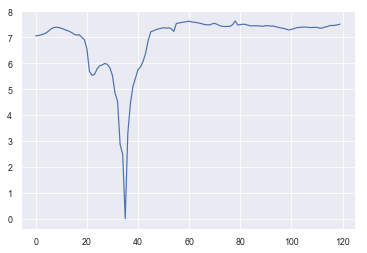

In [64]:
# development - this nearly stationarizes the data
# nah, just use the z-score for dropoffs

# armax_model = gen_arma_model(taxi_train, p, q, num_predict, exog = social_train, plot=False)
df_data = pd.DataFrame({'data':power_data})
# stationarize the data
# take daily differences
# take the log

df_diff_data = differencing(df_data, 24, 'data')
diff_data = np.array(df_diff_data['data'])

# shift so all data is above 0, then take log to stabilize
diff_data_shift = np.log(diff_data + np.abs(min(diff_data))+1.0)
plt.plot(diff_data_shift)
plt.show()
# alpha = 0.05

# stationary_bool_data, p_value_data = check_stationarity(my_data, significance_level=alpha, verbose=True)

# df_diff_taxi_train = differencing(df_diff_taxi_train, 24, 'dropoffs')

# optimal_arma_model = hyndman_arma_fit(df_diff_taxi_train['dropoffs'])


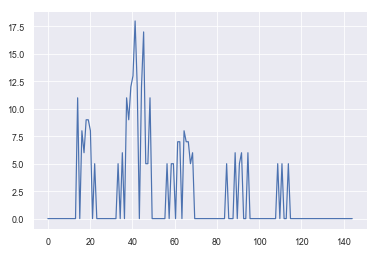

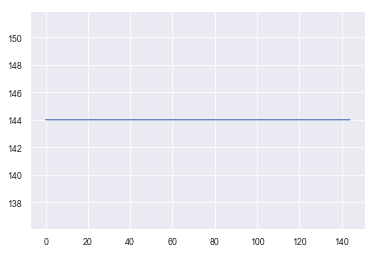

In [65]:
# linearly interpolate the twitter data b/c sparse data isn't fun
multiplier = 10
xp = social_data
fp = np.linspace(0, len(a), len(a))
points = np.linspace(0, len(a), multiplier*len(a))
plt.plot(fp, xp)
plt.show()

b = np.interp(points, xp, fp)
fp_points = np.linspace(0, len(a), multiplier* len(a))
plt.plot(fp_points, b)
plt.show()

# Exploratory Data Analysis
Make some plots

In [68]:
# plot_univariate_data(df_taxi['datetime'], df_taxi['ztrips-drop'])

In [69]:
# plot_univariate_data(df_power['datetime'], df_power['integrated_load'])   

In [71]:
# plot_univariate_data(df_social['datetime'], df_social['sandy-tweets-norm'])   

By visual inspection of the data, we notice that the number of tweets in the Times Square taxi zone spikes at the same time that both the NYISO integrated load and NYCTLC dropoffs achieve their lowest values.

# Result - Granger Causality

Be careful about the data you're showing causality with, the normalized social data doesn't work as well


Show that social media data Granger causes relevant critical infrastructures
1. Raw NYISO data with Twitter data
2. Raw NYCTLC data with Twitter data

In [72]:
result_nyiso = check_granger_causality(power_data, social_data, max_lag = 12, verbose = True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6319  , p=0.0331  , df_denom=140, df_num=1
ssr based chi2 test:   chi2=4.7312  , p=0.0296  , df=1
likelihood ratio test: chi2=4.6546  , p=0.0310  , df=1
parameter F test:         F=4.6319  , p=0.0331  , df_denom=140, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7824  , p=0.4594  , df_denom=137, df_num=2
ssr based chi2 test:   chi2=1.6218  , p=0.4445  , df=2
likelihood ratio test: chi2=1.6126  , p=0.4465  , df=2
parameter F test:         F=0.7824  , p=0.4594  , df_denom=137, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.3109  , p=0.0062  , df_denom=134, df_num=3
ssr based chi2 test:   chi2=13.6082 , p=0.0035  , df=3
likelihood ratio test: chi2=12.9909 , p=0.0047  , df=3
parameter F test:         F=4.3109  , p=0.0062  , df_denom=134, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.1273  , p=0.0035  

In [73]:
# TODO recheck after including trip abnormality + linearly interpolated twitter data
result_nyctlc = check_granger_causality(taxi_data, social_data, max_lag = 5, verbose = True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2236  , p=0.6371  , df_denom=140, df_num=1
ssr based chi2 test:   chi2=0.2284  , p=0.6327  , df=1
likelihood ratio test: chi2=0.2282  , p=0.6329  , df=1
parameter F test:         F=0.2236  , p=0.6371  , df_denom=140, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4851  , p=0.6167  , df_denom=137, df_num=2
ssr based chi2 test:   chi2=1.0056  , p=0.6048  , df=2
likelihood ratio test: chi2=1.0021  , p=0.6059  , df=2
parameter F test:         F=0.4851  , p=0.6167  , df_denom=137, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5420  , p=0.2066  , df_denom=134, df_num=3
ssr based chi2 test:   chi2=4.8677  , p=0.1817  , df=3
likelihood ratio test: chi2=4.7856  , p=0.1882  , df=3
parameter F test:         F=1.5420  , p=0.2066  , df_denom=134, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.2965  , p=0.0131  

## Discussion of Results
Null Hypothesis: the social media data does not Granger cause the other type of data for these lags

Accept if p >= 0.05

Reject if p < 0.05


The p-values for the Granger causality test show that social media data Granger causes the power data with lags 1-5.

The social media data also has some lagged response on the transportation data.  The p-values for lags 1 and 2 are greater than 0.05, meaning we accept the Null Hypothesis that the social media data does not Granger cause the transportation data for these lags.  However, for higher lags we find a p-value less than 0.05, meaning we reject the Null Hypothesis in these cases.

# Result - ARMA vs ARMAX

Show that social media data can be used to improve critical infrastructure performance forecasts (during a disaster) when using an ARMA-class model.

Specifically, we want to see a reduction in the forecast prediction intervals.  Note that we use prediction intervals instead of confidence intervals, since the prediction interval gives a more direct interpretation.  The PI is the estimated range of the forecast value, while the CI has to do with the forecast mean. 

See these links for more info

https://otexts.com/fpp2/prediction-intervals.html

https://www.graphpad.com/support/faq/the-distinction-between-confidence-intervals-prediction-intervals-and-tolerance-intervals/ 



## Transform Data to train Models
ARMA models require a stationary timeseries to work properly

In [76]:
#TODO add this to the gen arma model function
# stationarity checks with KPSS (Kwiatkowski-Phillips-Schmidt-Shin test for stationarity)
# according to KPSS, the raw data is stationary so there is no need for differencing
print('Power series')
power_stationarity = check_stationarity(df_power['integrated_load'], significance_level = 0.05, verbose = True)

print('\nTransportation Series')
transport_stationarity = check_stationarity(df_taxi['trip_count'], significance_level = 0.05, verbose = True)


Power series


C:\ProgramData\Miniconda3\envs\research\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


The timeseries is stationary with p-value of 0.1

Transportation Series


KeyError: 'trip_count'

In [ ]:
# # difference taxi data to fit ARMA model
# hours_diff_first = 24

# During the storm: since we only have a few days of data, only difference to deal with the observed daily trends
# hours_diff_second = 168

# df_taxi_diff_first = differencing(df_taxi, hours_diff = hours_diff_first, diff_col_str = 'trip_count')
# plot_univariate_data(df_taxi_diff_first['datetime'], df_taxi_diff_first['trip_count'])

# df_taxi_diff_second = differencing(df_taxi_diff_first, hours_diff = hours_diff_second, diff_col_str = 'trip_count')
# plot_univariate_data(df_taxi_diff_second['datetime'], df_taxi_diff_second['trip_count'])

# # difference power data to fit ARMA model
# df_power_diff_first = differencing(df_power, hours_diff=hours_diff_first, diff_col_str = 'integrated_load')
# plot_univariate_data(df_power_diff_first['datetime'], df_power_diff_first['integrated_load'])

# df_power_diff_second = differencing(df_power_diff_first, hours_diff = hours_diff_second,diff_col_str = 'integrated_load')
# plot_univariate_data(df_power_diff_second['datetime'], df_power_diff_second['integrated_load'])

# check stationarity of timeseries data
# print('\nDifferenced Power Series')
# power_stationarity = check_stationarity(df_power_diff_first['integrated_load'], 0.05, verbose = True)

# print('\nDifferenced Transportation Series')
# transport_stationarity = check_stationarity(df_taxi_diff_first['trip_count'], 0.05, verbose = True)


In [78]:
date_list = list(df_power['datetime'])

# split into train and test datasets (80% training, 20% testing)
train_proportion = int(np.floor(0.8*len(power_data)))

power_train = power_data[0:train_proportion]
power_test = power_data[train_proportion:]

taxi_train = taxi_data[0:train_proportion]
taxi_test = taxi_data[train_proportion:]

social_train = social_data[0:train_proportion]
social_test = social_data[train_proportion:]

date_train = date_list[0:train_proportion]
date_test = date_list[train_proportion:]


## ARMA Models
The ARMA model with only previous dropoffs as input has large confidence intervals.  With an exogenous input, we hope to see an reduction in the forecast confidence intervals.

### Transportation Data

In [79]:
# # example of working forecast
# y = np.random.random(100)
# x = np.random.random(100)
# newx = np.random.random(3)

# print(np.shape(y))
# print(np.shape(x))
# print(np.shape(newx))
# mod = ARMA(y, order=(2,1), exog=x).fit()
# f = mod.forecast(steps=3, alpha=.05, exog=newx)

In [92]:
# development
# generate and train models
p = 3
q = 3
alpha = 0.05
num_predict = 3
social_predict = social_test[0:num_predict]

arma_model = gen_arma_model(taxi_train, p, q, num_predict, plot=False)
# armax_model = gen_arma_model(taxi_train, num_predict, exog = social_train, \
#                                  plot=False, max_arma_param = 3, verbose = True)


C:\ProgramData\Miniconda3\envs\research\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

In [ ]:
# development
print(armax_model.aic)

In [ ]:
# # generate and train models
# p = 3
# q = 3
# alpha = 0.05
# num_predict = 3
# social_predict = social_test[0:num_predict]

# arma_model = gen_arma_model(taxi_train, p, q, num_predict, plot=False)
# armax_model = gen_arma_model(taxi_train, p, q, num_predict, exog = social_train, plot=False)

In [ ]:
# use models to generate forecasts and prediction intervals
# # ARMA forecast
forecast, stderr, conf = arma_model.forecast(alpha=alpha, steps = num_predict)
pi_range_arima = np.abs(stderr[1] - stderr[0])
print('PI Range ARIMA: ', pi_range_arima)

# ARMAX forecast
forecast, stderr, conf = armax_model.forecast(steps = num_predict, alpha=alpha, exog=social_predict)
pi_range_arimax = np.abs(stderr[1] - stderr[0])
print('PI Range ARIMAX: ', pi_range_arimax)

In [ ]:
# the arma model quickly converges to the mean of the series, especially with small p, q
# this is why these types of models are only good for short-term predictions
num_training_points_plot = 20
hours_forecast = 4

compare_arma_armax(arma_model, armax_model, hours_forecast, num_training_points_plot, exog=social_data)

### Power Data

In [ ]:
# arma_model = gen_arma_model(power_train, 2, 3, 2, plot=False)
# armax_model = gen_arma_model(power_train, 2, 3, 2, exog = social_train, plot=False)

In [ ]:
# num_training_points_plot = 20
# hours_forecast = 2
# compare_arma_armax(arma_model, armax_model, hours_forecast, num_training_points_plot, exog=social_data)

# Result - Best Models for Various Start Times